In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from deep_hedging import (
    Underlyings,
    Ticker,
    ConstantRateCurve,
    EuropeanCall,
)
from deep_hedging.hedger import HedgeSimulator
from deep_hedging.monte_carlo import GBMPricer

RANDOM_SEED = 12

In [3]:
N_PATHS = 100_000
N_STOCKS = 1
TILL_MATURITY = 3.0
N_DAYS = 365 * TILL_MATURITY
RF_RATE = 0.03
VOL = 0.2

In [4]:
np.random.seed(RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=N_DAYS)

underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
    start=start,
    end=end,
    dividends=np.array([0.0] * N_STOCKS),
    means=np.array([RF_RATE] * N_STOCKS),
    var_covar=np.array([VOL**2] * N_STOCKS),
)
underlyings.data

In [5]:
curve = ConstantRateCurve(constant_rate=RF_RATE)

In [6]:
european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=1.0,
    start_date=start,
    end_date=end,
)

In [7]:
pricer = GBMPricer(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)

In [8]:
paths = pricer.get_paths(
    spot=[1.0],
    time_till_maturity=TILL_MATURITY,
    risk_free_rate_fn=curve.get_instant_fwd_rate,
    dividends_fn=lambda t: 0.0,
    var_covar_fn=lambda t: np.array([VOL**2] * len(t)),
    n_paths=N_PATHS,
).squeeze(2)
paths.shape

(100000, 757)

In [9]:
hedger = HedgeSimulator(european_call, look_ahead=True)

In [10]:
pnl_hedge, pnl_opt = hedger.simulate(
    bids=paths,
    asks=paths,
    rates_lend=curve(european_call.days_till_maturity) / 365,
    rates_borrow=curve(european_call.days_till_maturity) / 365,
)
pnl_hedge.mean(), pnl_opt.mean()

(0.021178108966897022, 0.19572822393987255)

In [11]:
pnl_opt.std(), pnl_hedge.std(), (pnl_hedge - pnl_opt).std()

(0.30107502584781826, 0.30562672009191216, 0.00814353512928601)

In [12]:
np.corrcoef(pnl_hedge, pnl_opt)

array([[1.        , 0.99975222],
       [0.99975222, 1.        ]])

In [13]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).mean()

-0.0001238017003800206

In [14]:
(
    pnl_opt - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.30107502584781826

In [15]:
(
    pnl_opt
    - pnl_hedge
    - european_call.price() * np.exp(RF_RATE * european_call.time_till_maturity)
).std()

0.00814353512928601

In [16]:
paths.shape

(100000, 757)

In [17]:
example_spot = np.array([100, 100, 150]).reshape(1, -1, 1)
example_weights = np.array([0.5, 1.0, 2.0]).reshape(1, -1)

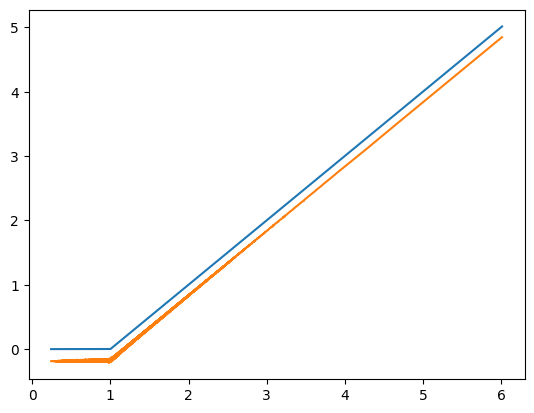

In [18]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

In [19]:
value_opt = european_call.price(spot=paths[:, -1])
value_opt.shape

(100000, 1)

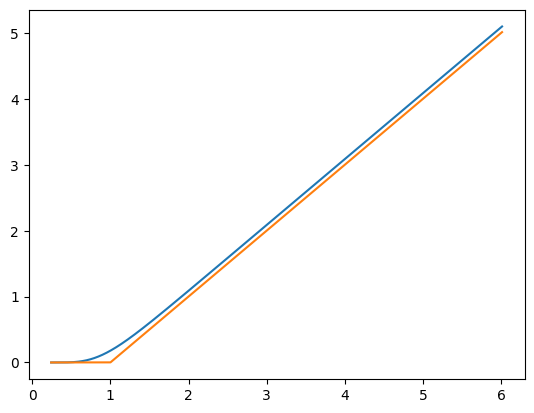

In [20]:
plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
# plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

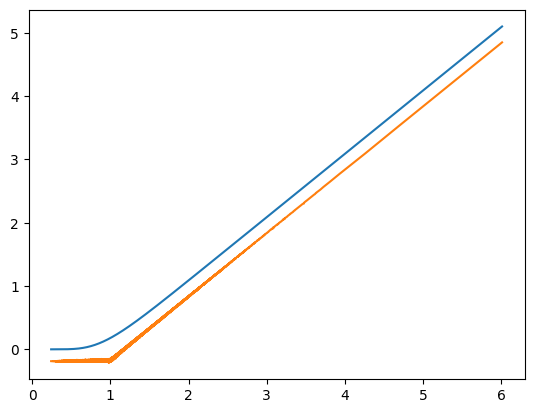

In [21]:
plt.plot(np.sort(paths[:, -1]), value_opt[np.argsort(paths[:, -1])])
# plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(np.sort(paths[:, -1]), pnl_hedge[np.argsort(paths[:, -1])])
plt.show()

In [22]:
np.sort(paths[:, -1])

array([0.24188876, 0.25198596, 0.26571973, ..., 4.26203288, 4.71964847,
       6.01329925])

In [23]:
pnl_opt[np.argsort(paths[:, -1])].shape

(100000,)

In [24]:
pnl_opt

array([0.        , 0.        , 0.        , ..., 0.        , 0.01635643,
       0.31403456])

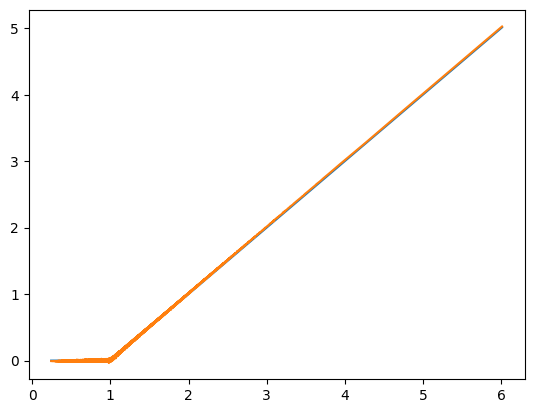

In [25]:
plt.plot(np.sort(paths[:, -1]), pnl_opt[np.argsort(paths[:, -1])])
plt.plot(
    np.sort(paths[:, -1]),
    pnl_hedge[np.argsort(paths[:, -1])] + european_call.price().T.squeeze(1),
)
plt.show()